# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [66]:
import time
import itertools
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import Mag
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'
plt.rc('font', family='serif')#, serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('legend', handlelength=2)
plt.rc('axes', titlesize=20)

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [2]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, J, gx, gz=0): # gx is transverse field, gz the longitudinal
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

### Load VQE parameters

In [3]:
def sort_vals(vals):
    """ vals is (unsorted) dictionary of parameters from VQE ansatz circuit, this returns sorted values as list """
    indices = np.array([_.index for _ in vals])           # unordered list of indices from the ParameterVectorElement(Theta(INDEX))
    vals_sorted = np.array([vals[_] for _ in vals])       # unordered list of values (but same ordering as indices)
    return vals_sorted[np.argsort(indices)]

def init_vqe(vals, L):
    #return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(sort_vals(vals))
    return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(vals)

In [4]:
L = 5
anti = -1
#filename = f'data/params_VQE_Ising_L{L}_anti_{anti}.npz'   # name of the data file that is used
filename = f'data/params_VQE_Ising_L{L}_anti_{anti}_50x50.npz'

VQE_vals = np.load(filename, allow_pickle=True)
gxs = VQE_vals['gx_list']
gzs = VQE_vals['gz_list']
phis = VQE_vals['opt_params']
N = int(np.sqrt(gxs.size))
gxs = np.logspace(-2, 2, N)#gxs.reshape(N,N)
gzs = np.logspace(-2, 2, N)#gzs.reshape(N,N)
phis = phis.reshape(N,N,-1) #(gx, gz)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [5]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 5 # system size
num_trash = 2
thetas = np.random.uniform(0, 2*np.pi, num_trash*L+num_trash) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [86]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    #if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.ry(thetas[2*L], 4)
    circ.ry(thetas[2*L+1], 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    return circ

# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit3(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash)#?, 'c')
    circ = QuantumCircuit(qreg, creg)
    
    print(circ.cregs)
    if init_state is not None:
        if not vqe:
            circ.initialize(init_state, qreg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state, L) + circ
        #else:
         #   circ.initialize(init_state, qreg)
    return circ

In [14]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [8]:
idx = 30
J, gx, gz = -1., gxs[idx], gzs[idx]
phi = phis[idx, idx]

def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit3(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, memory=True)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, L, num_trash, phi)

<ipython-input-6-b7459cb2fee9>:91: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state, L) + circ
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


{'01': 19, '10': 3, '00': 65, '11': 13}

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [9]:
#reset random seed
np.random.seed(123)

In [49]:
def hamming_distance(out):
    return sum(key.count('1') * value for key, value in out.items())   

def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0, model="bh"):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        if model=="ising": 
            J, gx, gz = p
            init_state, _ = ising_groundstate(L, J, gx, gz)
        elif model=="bh":
            init_state = p#init_states[p]
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = hamming_distance(out)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=500, lr=None, perturbation=None, vqe=True, param_encoding=False, x=0):
    if thetas is None:
        n_params = (num_trash*L+num_trash)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    # optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    optimizer = SPSA(maxiter=max_iter,
                     #blocking=True,
#                      callback=store_intermediate_result,
                     learning_rate=lr,
                     perturbation=perturbation
                     ) # recommended from qiskit (first iteraction takes quite long)
                       # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

In [48]:
thetas, loss, accepted = optimize(params, L, 2, max_iter=itera)

Initial cost: 0.920
Time: 42.72509 sec
(array([2.55831235, 0.62500549, 5.84179735, 1.50671164, 1.6167678 ,
       3.14890431, 3.13333808, 3.1265901 , 4.72959474, 4.70466185,
       6.86876898, 5.05374468]), 0.003, 500)


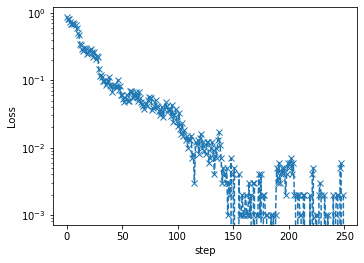

In [43]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(losses[2,1,:], "x--") #2,2   1,2
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

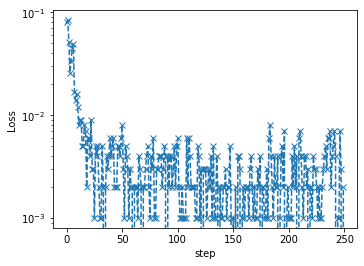

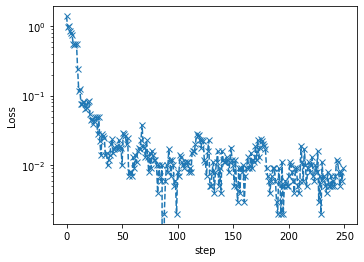

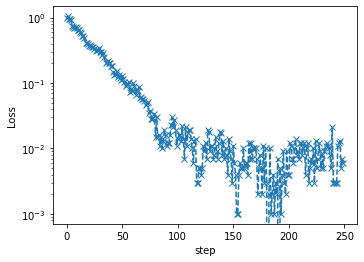

In [45]:
for i,lr in enumerate(lrs):
    for j,p in enumerate(perturbations):
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(losses[i,j,:], "x--")
        plt.yscale("log")
        plt.xlabel("step")
        plt.ylabel("Loss");

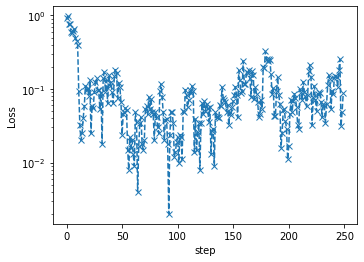

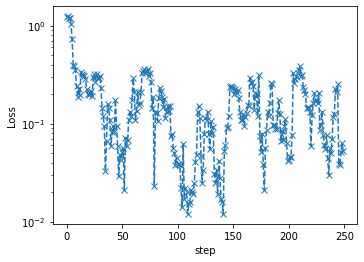

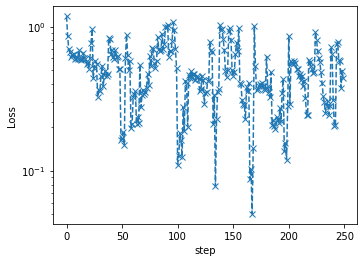

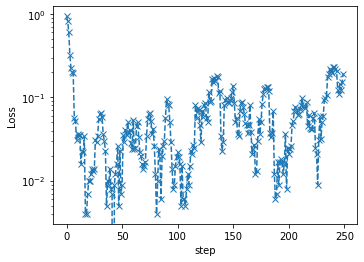

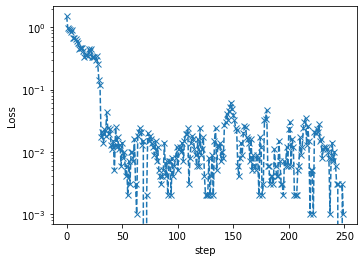

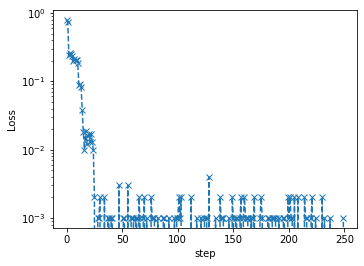

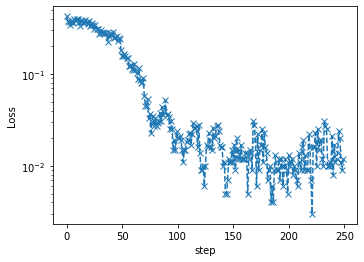

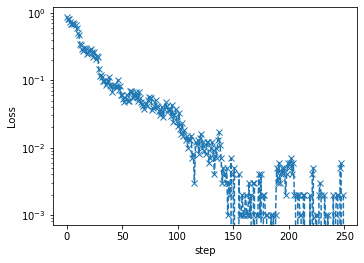

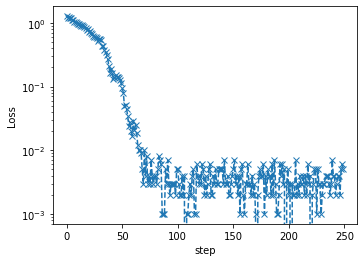

In [36]:
for i,lr in enumerate(lrs):
    for j,p in enumerate(perturbations):
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(losses[i,j,:], "x--")
        plt.yscale("log")
        plt.xlabel("step")
        plt.ylabel("Loss");

In [18]:
params = [(13,13)]
num_trash = 2
print(gxs[params[0][0]], gzs[params[0][1]])
thetas, loss, accepted = optimize(params, L, 2, max_iter=40)
thetas_normal_phase_2 = thetas

0.1151395399326447 0.1151395399326447
Initial cost: 1.110
Time: 9.25927 sec
(array([3.06214627, 4.01680488, 0.46630726, 4.67867738, 3.13276354,
       3.51913829, 2.32652368, 1.67647227, 3.16385283, 3.18711396,
       5.25603257, 2.88970313]), 0.058, 120)


In [22]:
len(loss)

40

In [20]:
params = [(13,13)]
num_trash = 2
print(gxs[params[0][0]], gzs[params[0][1]])
thetas, loss, accepted = optimize(params, L, 2, max_iter=40)
thetas_normal_phase_2 = thetas

0.1151395399326447 0.1151395399326447
Initial cost: 0.823
Time: 13.13156 sec
(array([ 4.19417388e+00,  1.39652564e+00,  2.98503811e+00,  3.06319411e+00,
        6.31694988e+00, -4.54683418e-03,  6.45675219e+00,  3.84156816e+00,
       -5.12710114e-02,  3.13917777e+00,  9.32007653e-02,  6.73074897e+00]), 0.004, 120)


In [11]:
params = [(18,38)]
thetas_test, loss, accepted = optimize(params, L, max_iter=40)

Initial cost: 1.424
Time: 14.27579 sec
(array([5.45734183, 1.17942628, 1.06928246, 4.64263077, 4.63882798,
       3.22436746, 6.35135721, 3.10026798, 1.56957626, 1.51678142,
       1.11879715, 3.97096917]), 0.005, 120)


In [210]:
params = [(13,13)]
thetas_test, loss, accepted = optimize(params, 5, 2, max_iter=40, vqe=False)

Initial cost: 1.101
Time: 10.28256 sec
(array([-0.14844581,  2.77815889, -1.60475003,  3.16465567,  3.26435023,
        4.775246  ,  1.85663655,  5.82447654,  0.05813272,  6.12775264,
        4.08582567,  3.02215344]), 0.004, 120)


## Longitudinal transverse field Ising model

In [132]:
L = 5
anti = -1
# filename = f'data/params_VQE_Ising_L{L}_anti_{anti}.npz'   # name of the data file that is used
filename = f'data/params_VQE_Ising_L{L}_anti_{anti}_50x50.npz'

VQE_vals = np.load(filename, allow_pickle=True)
gxs = VQE_vals['gx_list']
gzs = VQE_vals['gz_list']
phis = VQE_vals['opt_params']
N = int(np.sqrt(gxs.size))
gxs = np.logspace(-2, 2, N)#gxs.reshape(N,N)
gzs = np.logspace(-2, 2, N)#gzs.reshape(N,N)
phis = phis.reshape(N,N,-1) #(gx, gz)

### Train with two different states from each normal "fake phase"

In [ ]:
params = [(16,37),(37,16)]
num_trash = 2
print(gxs[params[0][0]], gzs[params[0][1]])
thetas, loss, accepted = optimize(params, L, num_trash)
thetas_normal_phase_2 = thetas

<ipython-input-465-5ad8660e9b3c>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


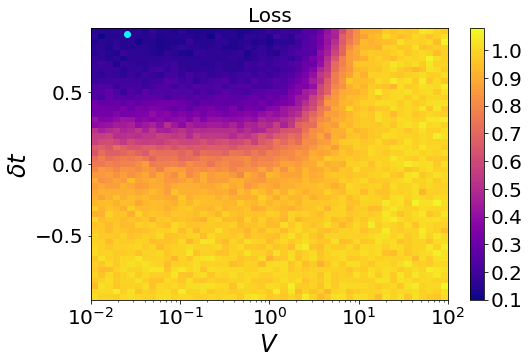

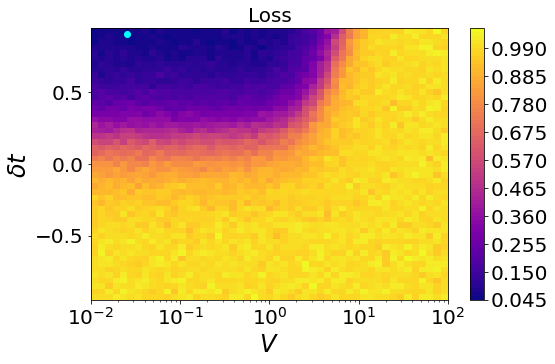

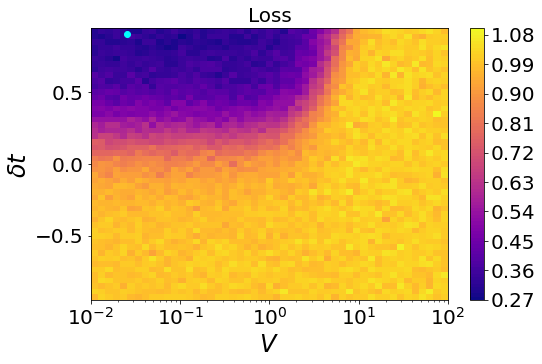

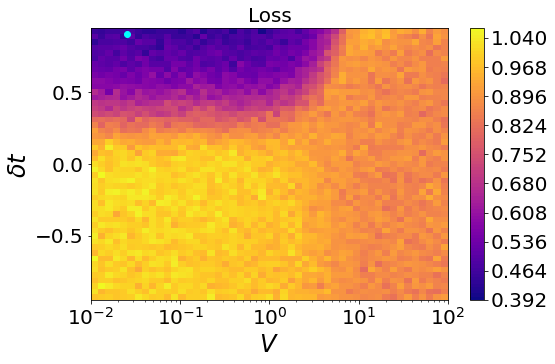

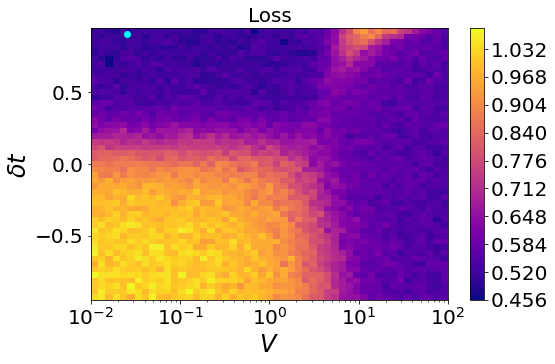

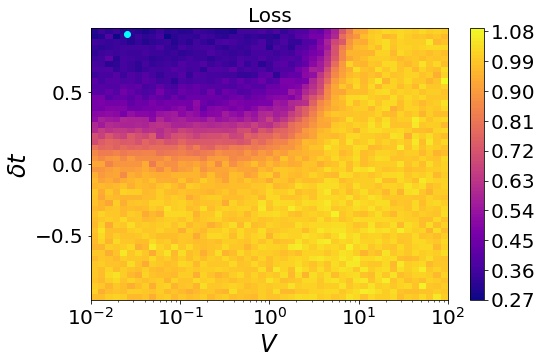

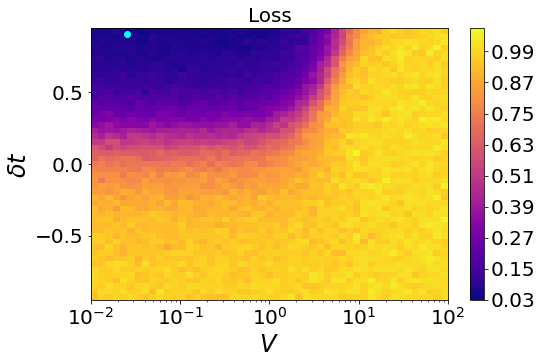

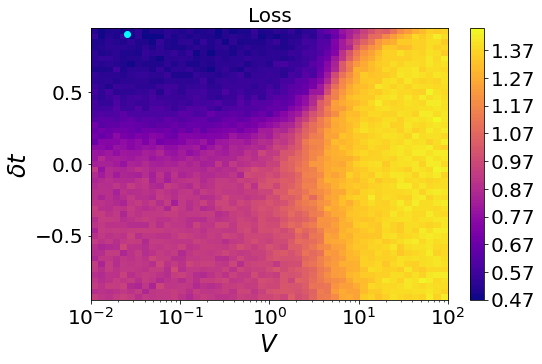

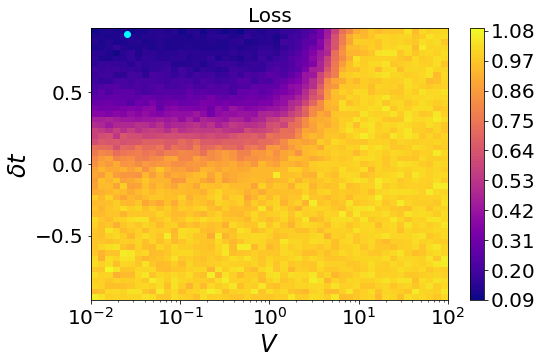

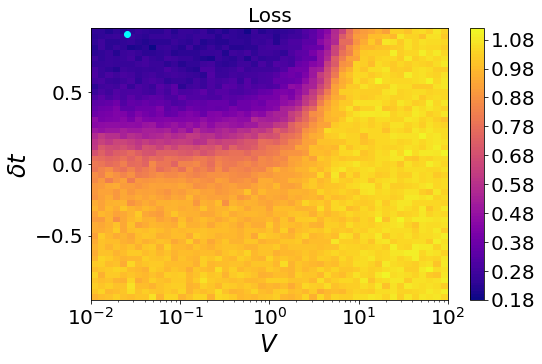

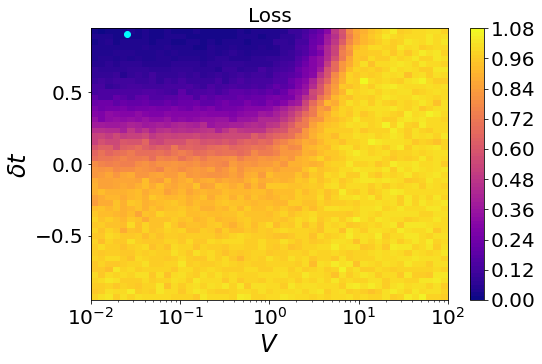

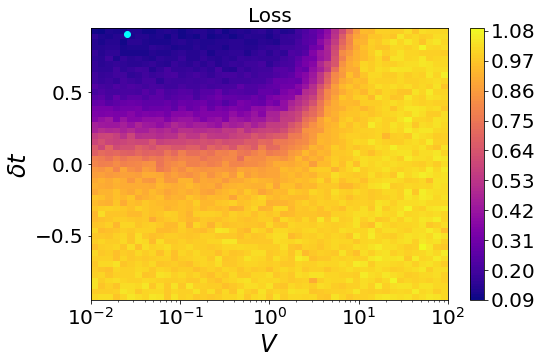

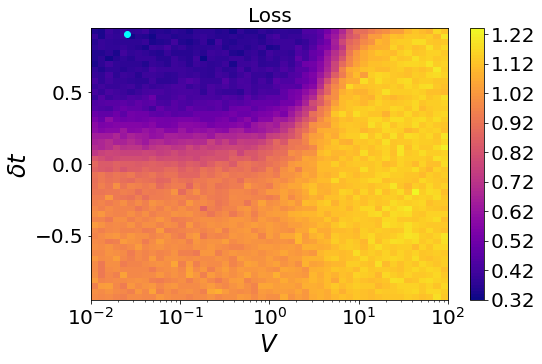

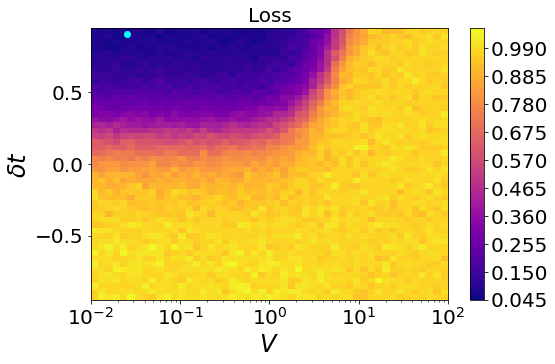

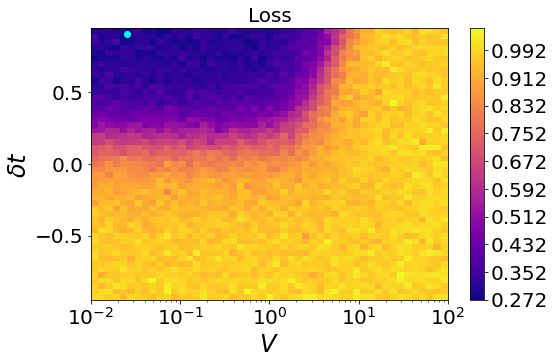

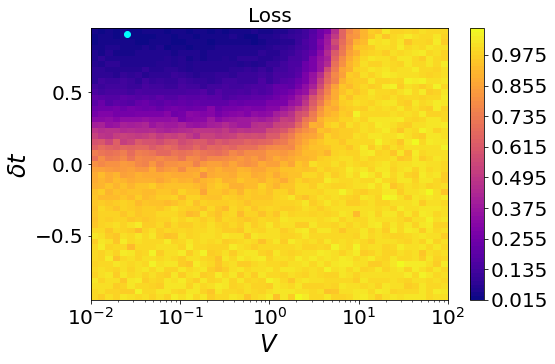

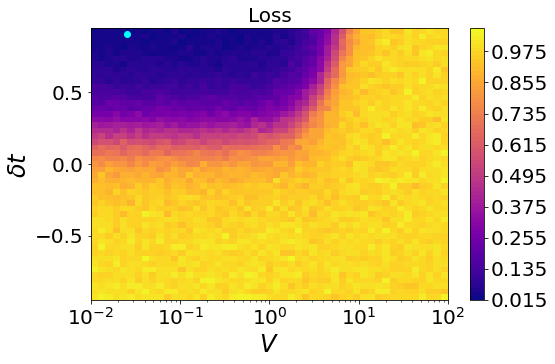

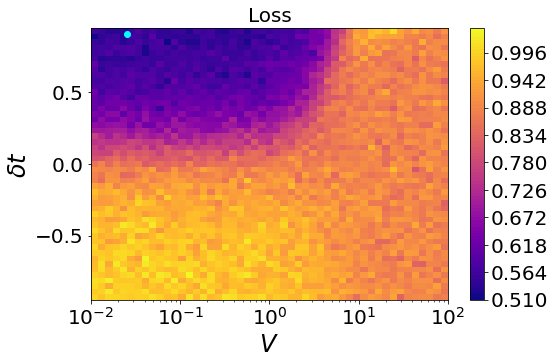

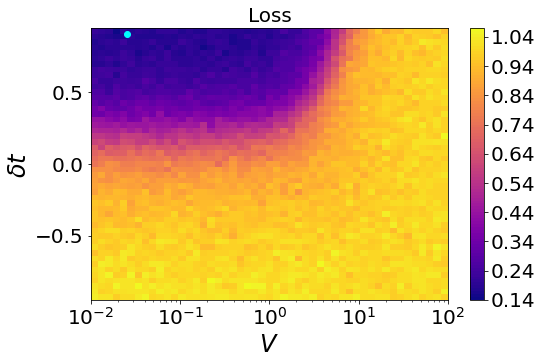

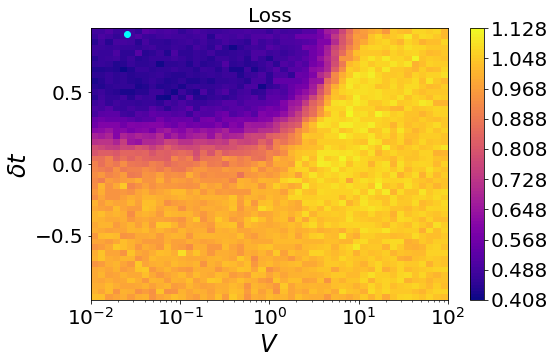

In [465]:
seeds = np.arange(20) + 10
for seed in seeds:
    cost = np.load(f'data_rike/cost_bh_L12_trash2_d48_v5_seed{seed}.npy', allow_pickle=True) # 7, 10
    params = [[48,5]]

#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d2_v5_seed{seed}.npy', allow_pickle=True) # -2
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d2_v5_seed{seed}.npy', allow_pickle=True)
#     params = [[2,5]]
    
#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d10_v10_seed{seed}.npy', allow_pickle=True) # 3, 6
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d10_v10_seed{seed}.npy', allow_pickle=True)
#     params = [[10,10]]
    
    fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
    nbins=100
    ax = axs[0,0]
    levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    plt.xscale("log")
    # plt.yscale("log")
    ax.set_title("Loss",fontsize=20)
    ax.set_xlabel(r"$V$",fontsize=24)
    ax.set_ylabel(r"$\delta t$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
    plt.show()

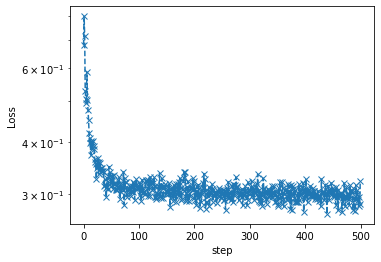

In [55]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [57]:
points = 50
J = -1.0
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
#Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, L, num_trash, (i,j), shots=shots)
        #init_state, _ = ising_groundstate(5, J, gx, gz)
        #Smags[i,j] = np.real(init_state.T.conj()@Mag(5,-1)@init_state)

1 trash qubit

<ipython-input-42-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-42-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


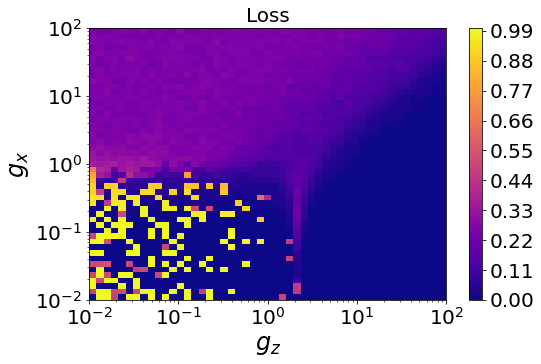

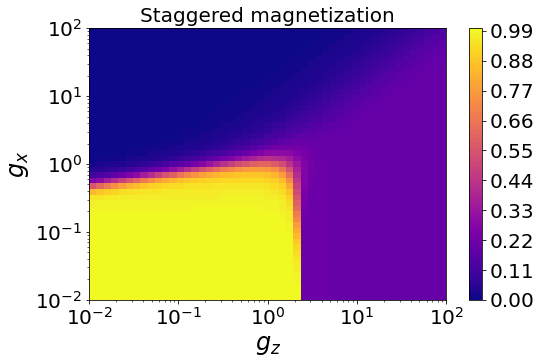

In [42]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

2 trash qubits

<ipython-input-58-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-58-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


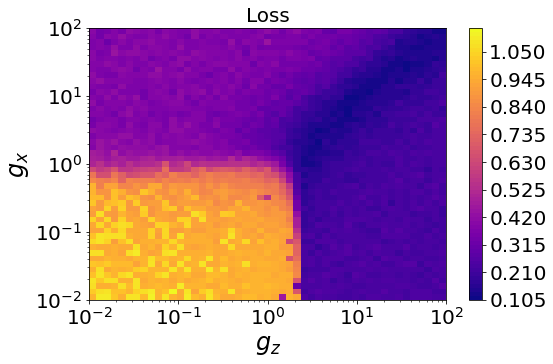

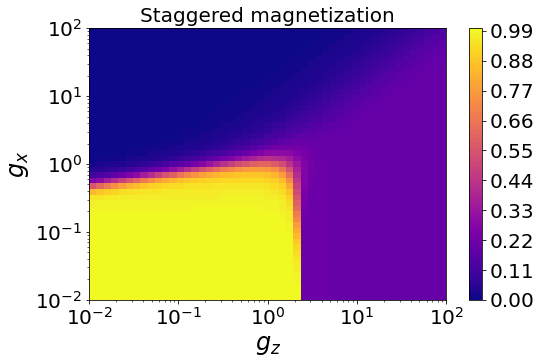

In [58]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [59]:
J = -1
gz = gzs[0]
cost1, Smags1, Smags12 = [], [], []
shots = 10000
Ll = 5
for i,gx in enumerate(gxs):
    cost1.append(cost_function_single(thetas, L, num_trash, (i, 0), shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags1.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    #init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    #Smags12.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
gx = gxs[0]
cost2, Smags2, Smags22 = [], [], []
for i,gz in enumerate(gzs):
    cost2.append(cost_function_single(thetas, L, num_trash, (0, i), shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags2.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    #init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    #Smags22.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))

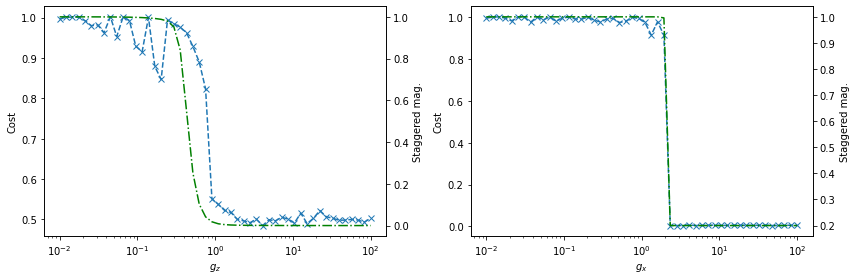

In [267]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
ax4 = ax3.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Cost")
ax1.plot(gzs, cost1, "x--")
ax2.plot(gzs, Smags1, "g-.")
#ax2.plot(gzs, Smags12, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Cost")
ax3.plot(gzs, cost2, "x--")
ax4.plot(gzs, Smags2, "g-.")
#ax4.plot(gzs, Smags22, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")
fig.tight_layout()

### Train in the ordered phase

In [133]:
params = [(13,13)]
num_trash = 4
print(gxs[params[0][0]], gzs[params[0][1]])
thetas, loss, accepted = optimize(params, L, num_trash)
thetas_ordered_phase_4 = thetas

0.1151395399326447 0.1151395399326447
Initial cost: 2.824
Time: 165.54154 sec
(array([ 8.03518069,  6.01052585,  4.59039703, -0.05037142,  3.09064307,
        0.19783346, -0.8191357 ,  8.0105851 ,  0.05961772,  3.45892735,
        1.48736181, -1.27415802, -2.28613711,  3.0744257 ,  4.03872928,
        3.42403605,  0.34311334,  2.69593475,  3.15795629,  4.24267232,
        1.45802466,  5.04759618,  2.77482827,  3.60380772]), 0.0, 1500)


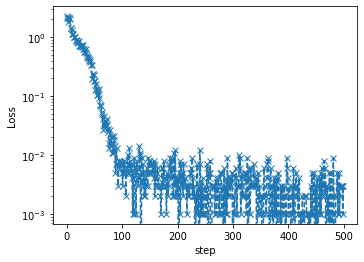

In [134]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [73]:
thetas = thetas_ordered_phase_2
num_trash = 2

In [135]:
points = 50
J = -1.0
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
#Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, L, num_trash, (i,j), shots=shots)
        #init_state, _ = ising_groundstate(5, J, gx, gz)
        #Smags[i,j] = np.real(init_state.T.conj()@Mag(5,-1)@init_state)

<ipython-input-65-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-65-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


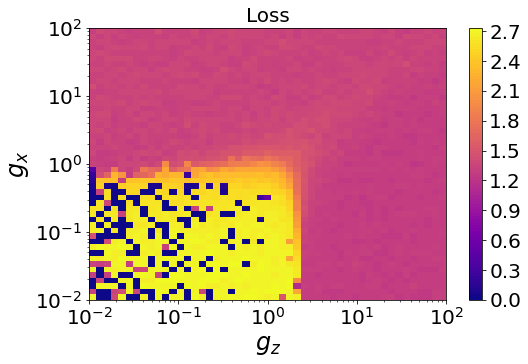

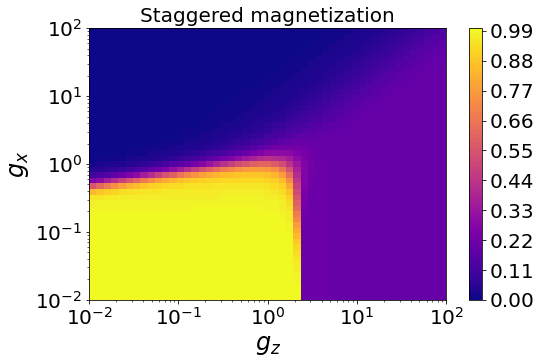

In [65]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)
# 3 trash qubits

<ipython-input-53-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-53-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


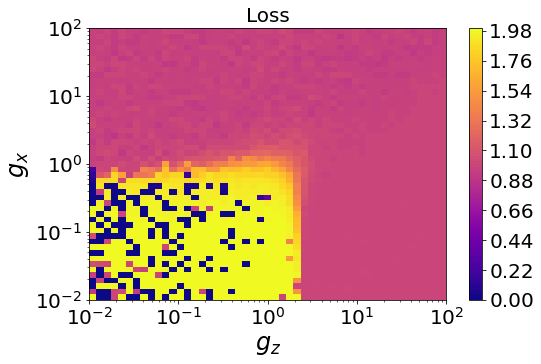

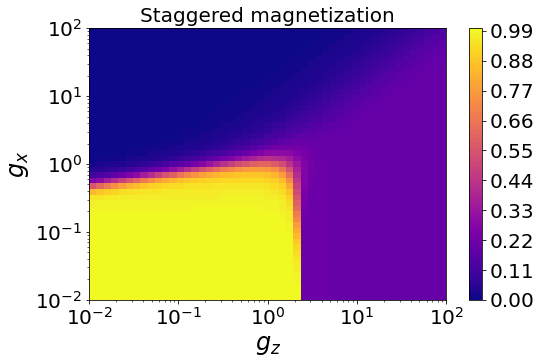

In [53]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)
# 2 trash qubits

<ipython-input-76-64c4c72a6670>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost_shift, cmap=cmap, norm=norm)
<ipython-input-76-64c4c72a6670>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


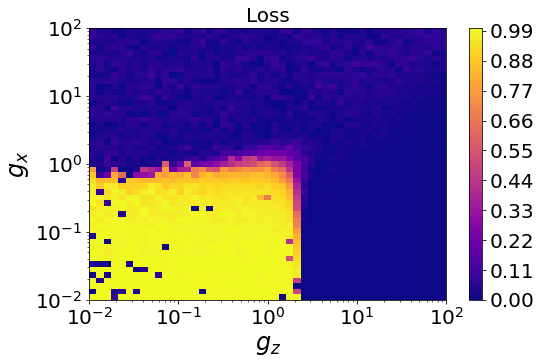

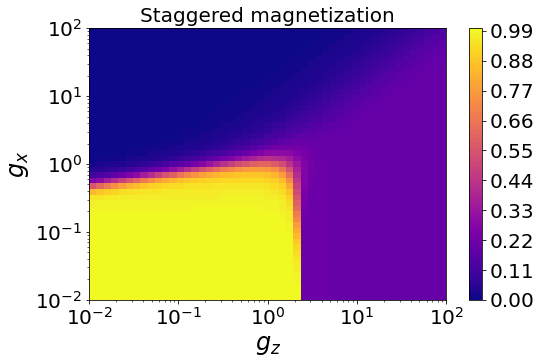

In [76]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
cost_shift = np.abs(1-cost)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost_shift.min(),cost_shift.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost_shift, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)
# 2 trash qubits

## Bose Hubbard

In [313]:
cmap = plt.get_cmap("plasma")
def plot_result(cost, params):
    fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
    nbins=100
    ax = axs[0,0]
    im = ax.pcolormesh(x, y, cost.T, cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_yscale("log")
#     plt.xscale("log")
    ax.set_title("Loss",fontsize=20)
    ax.set_ylabel(r"$V$",fontsize=24)
    ax.set_xlabel(r"$\delta t$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(d,V,"o",label="training",color="cyan")

In [64]:
L = 12
N = 50
#filename = f'data/wf_BH_L{L}.npz'
#filename = '../wf_BH_L20.npz'
#filename = 'data/wf_BH_L10_logV.npz'
filename = 'data/wf_BH_L12_logV_50x50.npz'


VQE_vals = np.load(filename, allow_pickle=True)
deltas = VQE_vals['deltat_array']
Vs = VQE_vals['V_array']
init_states = VQE_vals['wf_array']
# Vs = np.linspace(2,8,10)
# Vs = np.linspace(0,1,10)
Vs = np.logspace(-2,2,N)
# deltas = np.linspace(-1,1,10)
# deltas = np.linspace(-2,2,10)
deltas = np.linspace(-0.95,0.95,N)
init_states = init_states.reshape(N,N,-1) #(delta, V)

dd_vals = np.load('data/BH_dd_L12.npz', allow_pickle=True)
# deltas = dd_vals['deltat_array']
dd = dd_vals['dd_array'].reshape(N,N)
# init_states = VQE_vals['wf_array']
es_vals = np.load('data/BH_ES_L12.npz', allow_pickle=True)
es = es_vals['ES_array'].reshape(N,N)

In [424]:
print(deltas[48], Vs[1])

0.9112244897959185 0.012067926406393288


In [415]:
num_trash = 2
thetas, loss, accepted = optimize([init_states[-2,1]], L, num_trash, max_iter=1500, vqe=False)
thetas_bh12_10_2 = thetas

Initial cost: 1.059
Time: 2794.27413 sec
(array([ 5.51061251,  3.66285201,  4.19781978, -0.92886168,  2.44193361,
        6.60904788,  4.39162905,  4.03743943,  2.19951264, -0.16284558,
       -1.45847886,  0.78857737,  4.10878866,  7.85350836,  4.45876688,
        1.49162999, -1.30234149,  1.5546589 ,  2.93094681,  6.28285336,
        5.136626  , -0.04426571, -0.08161343,  3.20657619,  6.47385783,
        0.14872635]), 0.512, 4500)


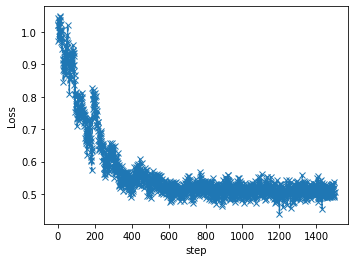

In [418]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
#plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [391]:
thetas = thetas_bh__1_2

In [60]:
points = 50
x,y = np.meshgrid(deltas,Vs)
# cost = np.zeros((points,points))
# Smags = np.zeros((points,points))
# shots = 1000
# for i,d in enumerate(deltas):
#     print(i)
#     for j,v in enumerate(Vs):
#         cost[i,j] = cost_function_single(thetas, L, num_trash, init_states[i,j], shots=shots, vqe=False)

cost_bh12__1_2 = cost

In [426]:
#cost_bh12_10_2 = cost
np.save(f'data_rike/cost_bh_L{L}_trash{num_trash}_d5_v50.npy', cost_bh12__1_2)

In [74]:
dd.shape

(50, 50)

In [77]:
np.save('../data_rike/es.npy', es)

In [78]:
x,y = np.meshgrid(deltas,Vs)

In [81]:
np.save('../data_rike/x.npy', y)

In [83]:
x

array([[-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ],
       [-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ],
       [-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ],
       ...,
       [-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ],
       [-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ],
       [-0.95      , -0.91122449, -0.87244898, ...,  0.87244898,
         0.91122449,  0.95      ]])

cost_bh12_00_2 = cost

<ipython-input-63-0dbb5859ec63>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


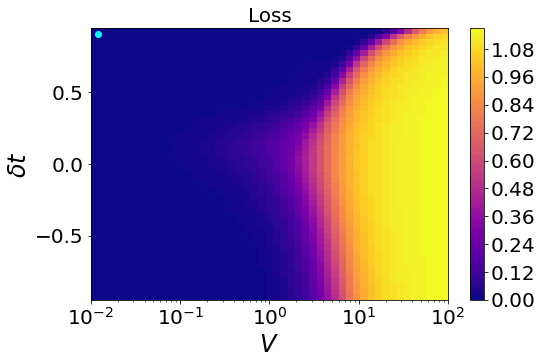

In [63]:
params = [[-2,1]]
cost = dd
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

<ipython-input-408-051f980cac4c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


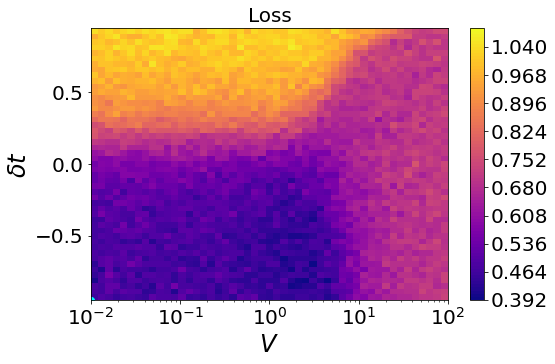

In [408]:
params = [[0,0]]
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

<ipython-input-402-266ed923f9aa>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


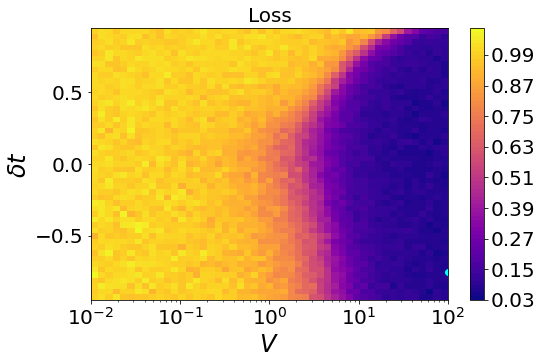

In [402]:
params = [[5,-1]]
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

### L=10

<ipython-input-386-051f980cac4c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


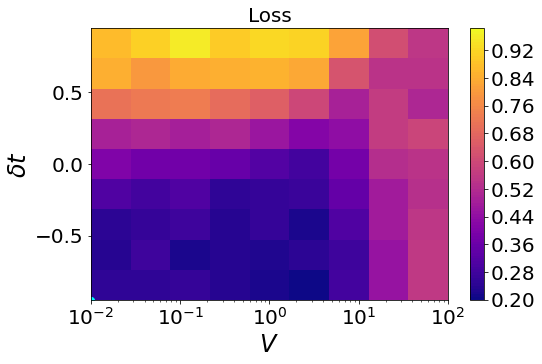

In [386]:
params = [[0,0]]
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

<ipython-input-389-fd5a54fb585c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


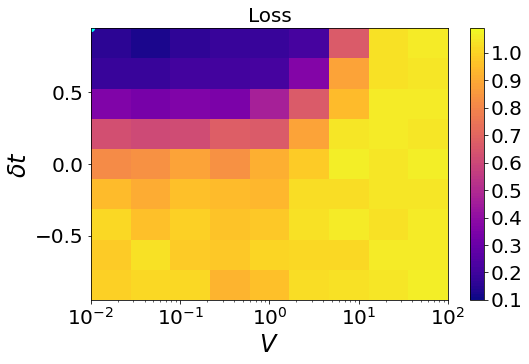

In [389]:
params = [[-1,0]]
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

<ipython-input-393-266ed923f9aa>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


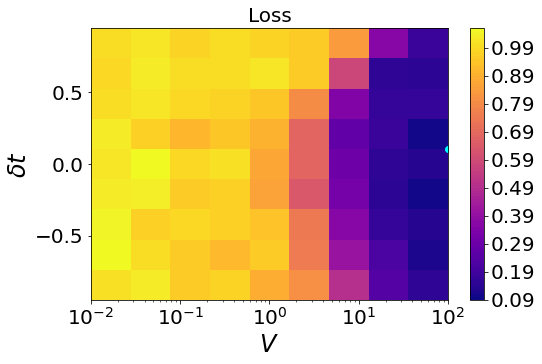

In [393]:
params = [[5,-1]]
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
#2 trash qubit

In [435]:
cost = np.load('data_rike/cost_bh_L12_trash2_d48_v5_seed10.npy', allow_pickle=True)

<ipython-input-72-f22b320a71c8>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


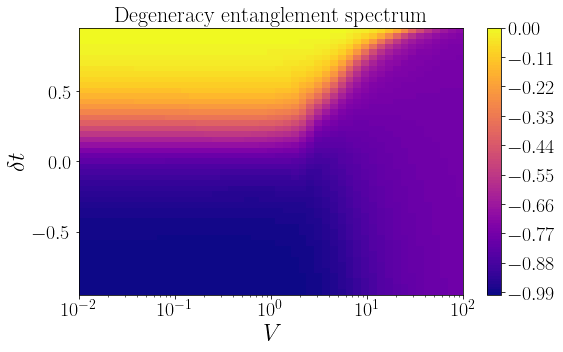

In [72]:
# cost = np.load('data_rike/cost_bh_L12_trash6_d25_v47_seed29.npy', allow_pickle=True)
params = [[25,47]]
cost = es
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
# plt.yscale("log")
# ax.set_title("Density-density correlation",fontsize=22)
# ax.set_title("Loss",fontsize=22)
ax.set_title("Degeneracy entanglement spectrum",fontsize=22)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
# for p in params:
#         d = deltas[p[0]]
#         V = Vs[p[1]]
#         ax.plot(V,d,"o",label="training",color="cyan")
fig.tight_layout()
# plt.savefig('plots_rike/cost_bh_L12_trash6_d25_v47_seed29.png', dpi=300)
plt.savefig('plots_rike/es_bh_L12.pdf', dpi=300)

<ipython-input-519-3dd7f9917963>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


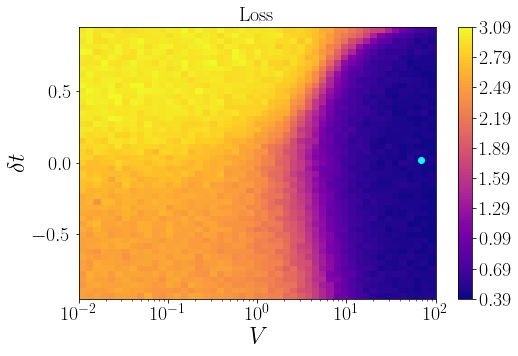

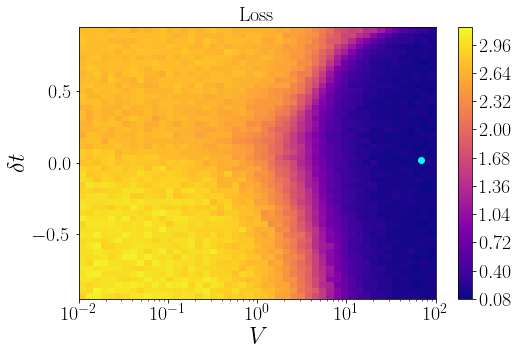

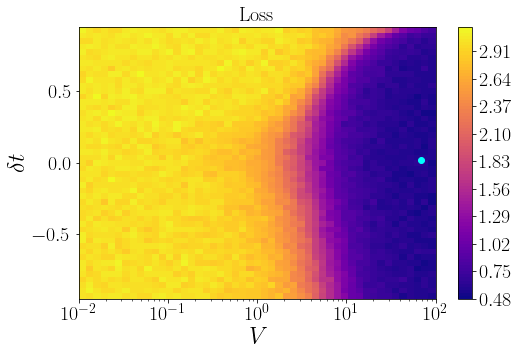

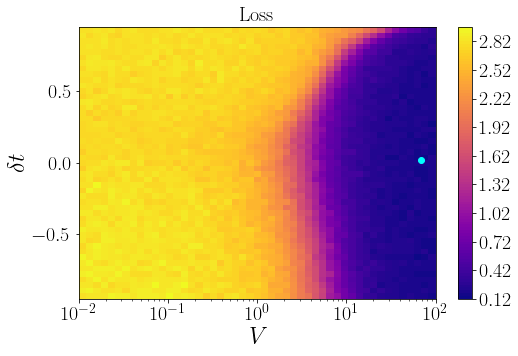

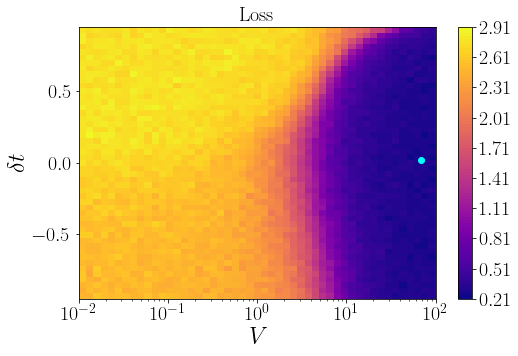

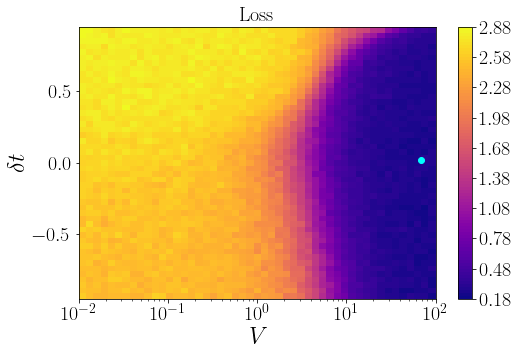

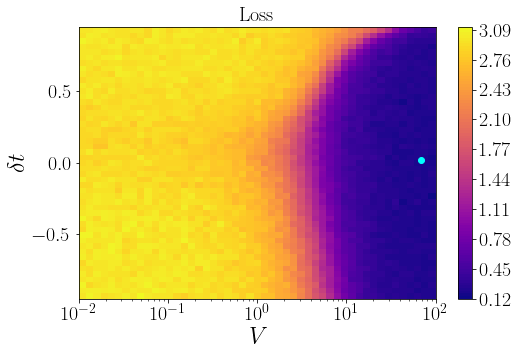

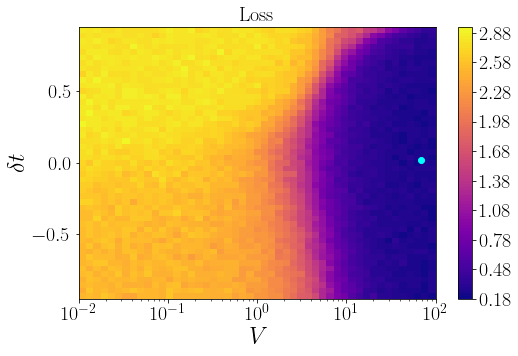

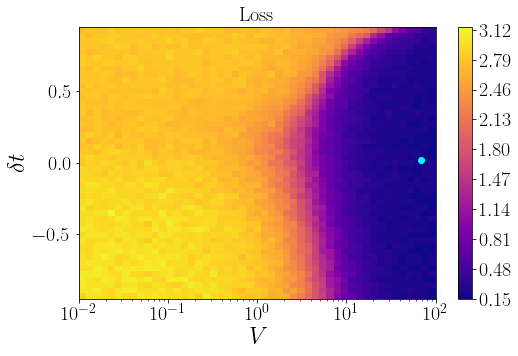

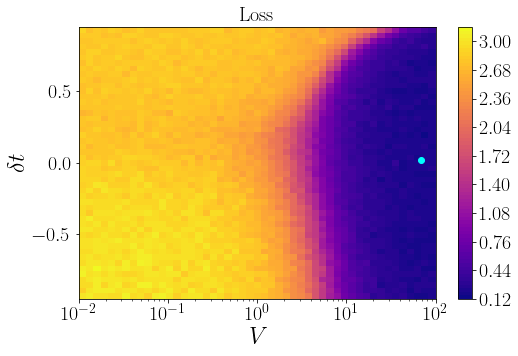

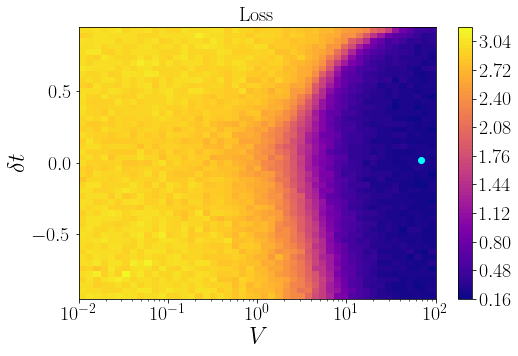

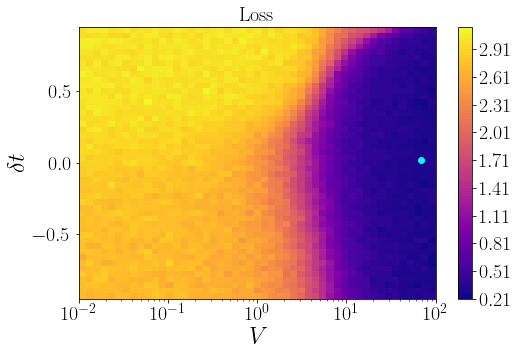

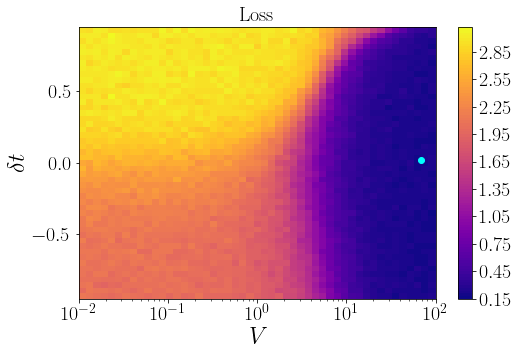

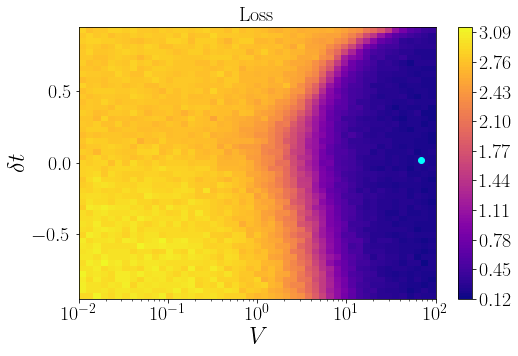

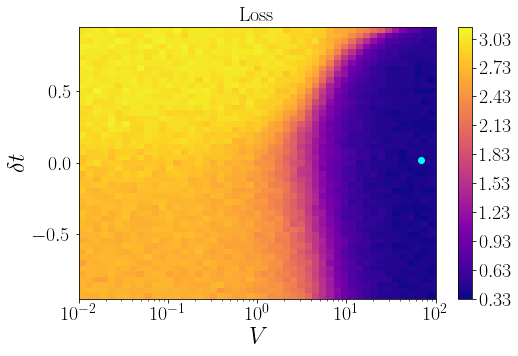

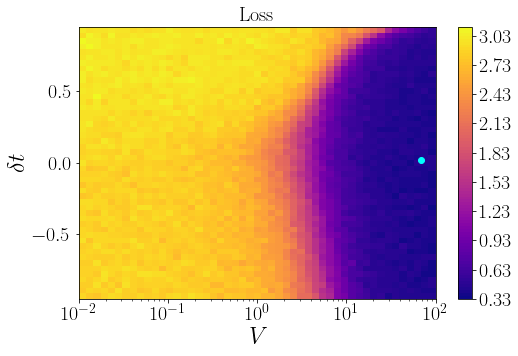

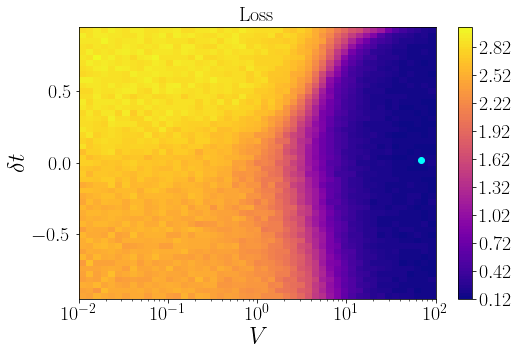

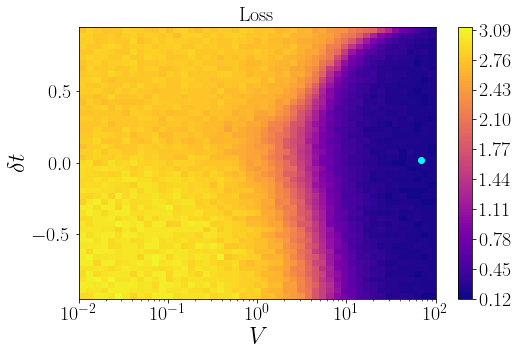

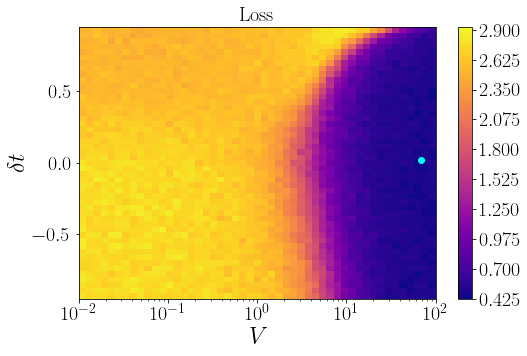

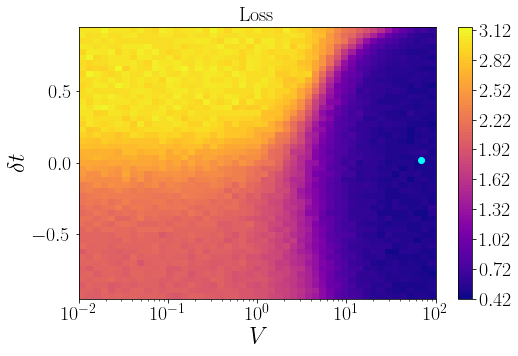

In [519]:
seeds = np.arange(20) + 10
for seed in seeds:
#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d48_v5_seed{seed}.npy', allow_pickle=True) # 7, 10
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d48_v5_seed{seed}.npy', allow_pickle=True) # 3
#     cost = np.load(f'data_rike/cost_bh_L12_trash6_d48_v5_seed{seed}.npy', allow_pickle=True) # 0
#     params = [[48,5]]

#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d2_v5_seed{seed}.npy', allow_pickle=True) # -2
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d2_v5_seed{seed}.npy', allow_pickle=True) # 0
#     cost = np.load(f'data_rike/cost_bh_L12_trash6_d2_v5_seed{seed}.npy', allow_pickle=True) # 2, 10
#     params = [[2,5]]
    
#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d10_v10_seed{seed}.npy', allow_pickle=True) # 3, 6
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d10_v10_seed{seed}.npy', allow_pickle=True) # -8
#     cost = np.load(f'data_rike/cost_bh_L12_trash6_d10_v10_seed{seed}.npy', allow_pickle=True) # 6, 12
#     params = [[10,10]]
    
#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d25_v47_seed{seed}.npy', allow_pickle=True) # 1
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d25_v47_seed{seed}.npy', allow_pickle=True) # 6
    cost = np.load(f'data_rike/cost_bh_L12_trash6_d25_v47_seed{seed}.npy', allow_pickle=True) # 1, 12, 19
    params = [[25,47]]
    
    fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
    nbins=100
    ax = axs[0,0]
    levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    plt.xscale("log")
    # plt.yscale("log")
    ax.set_title("Loss",fontsize=20)
    ax.set_xlabel(r"$V$",fontsize=24)
    ax.set_ylabel(r"$\delta t$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
            d = deltas[p[0]]
            V = Vs[p[1]]
            ax.plot(V,d,"o",label="training",color="cyan")

<ipython-input-465-5ad8660e9b3c>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)


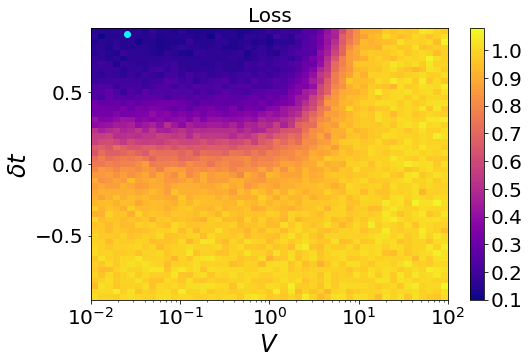

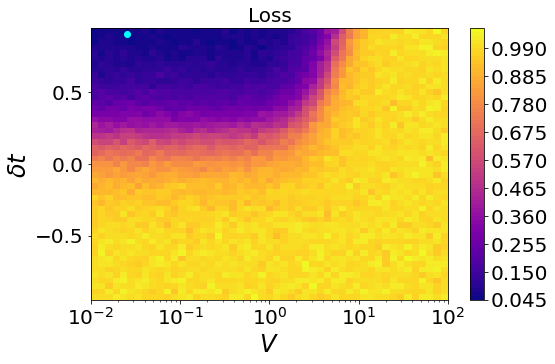

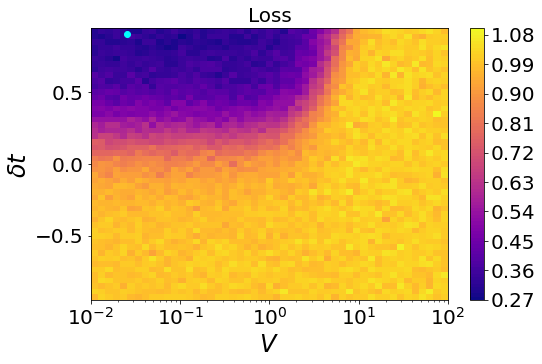

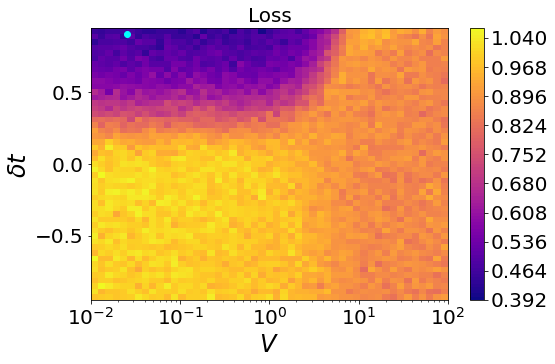

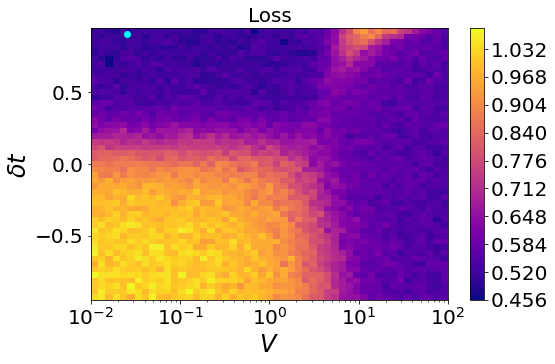

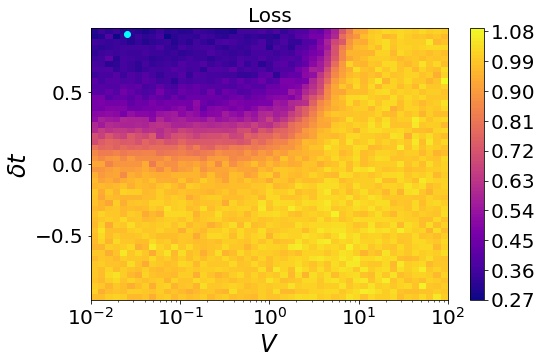

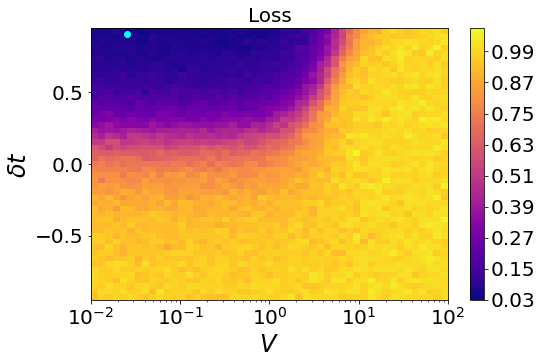

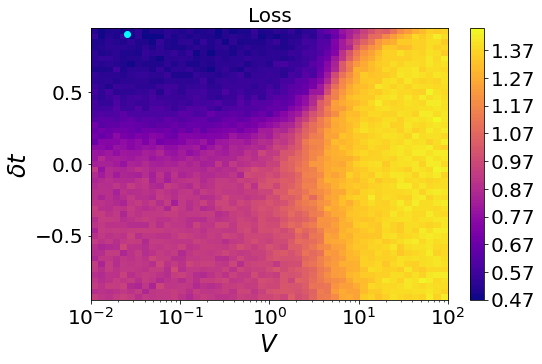

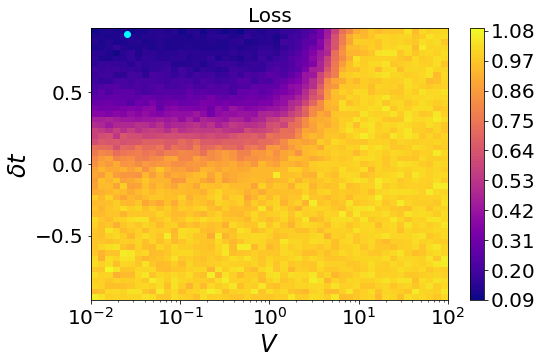

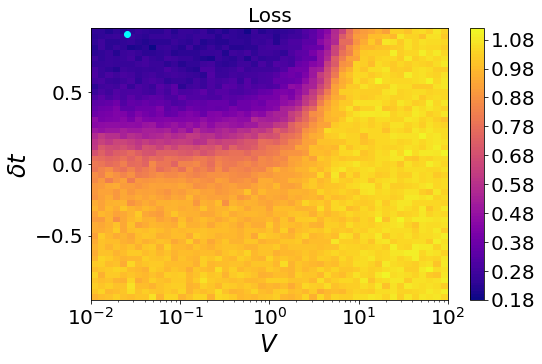

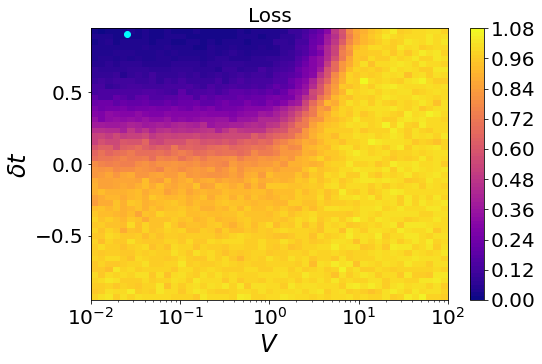

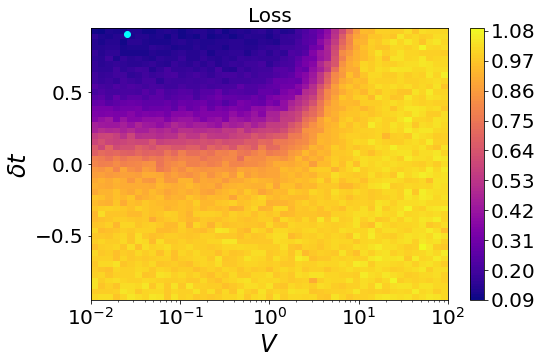

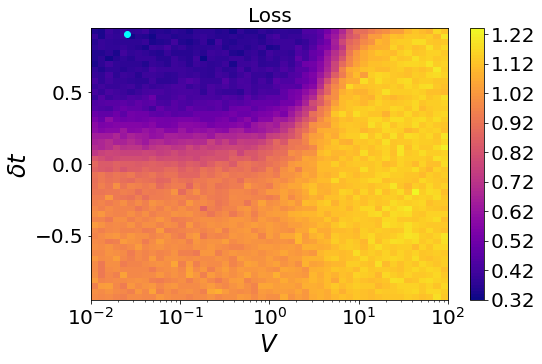

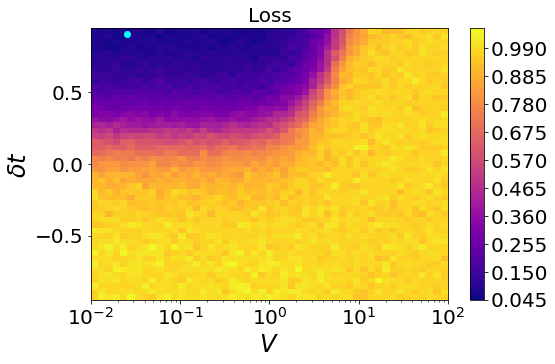

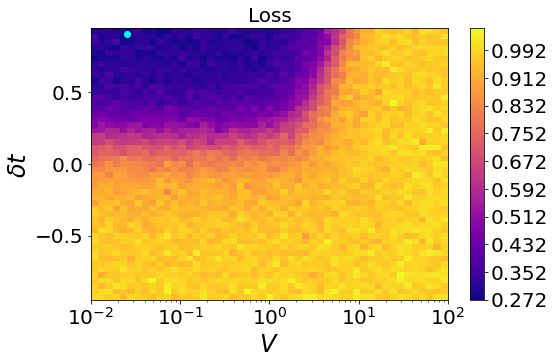

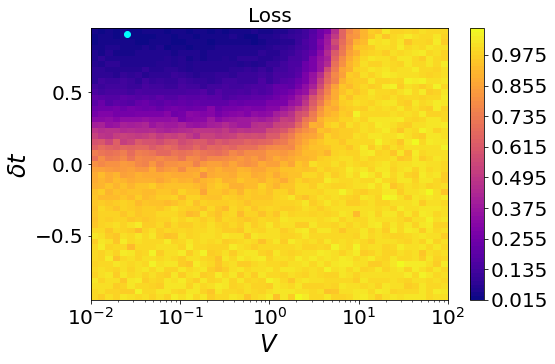

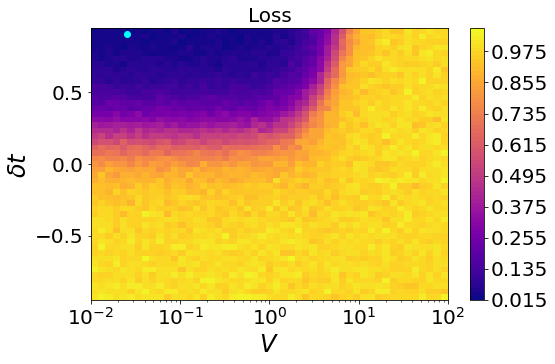

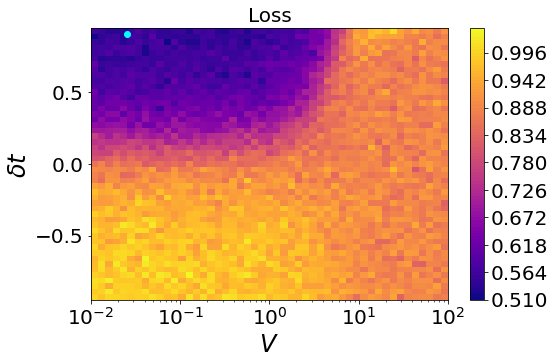

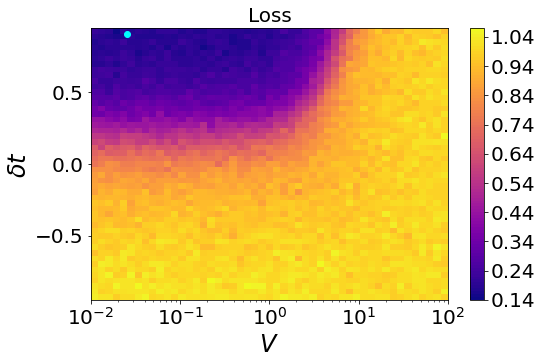

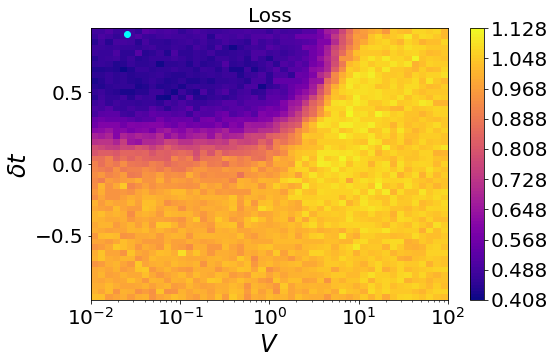

In [465]:
seeds = np.arange(20) + 10
for seed in seeds:
    cost = np.load(f'data_rike/cost_bh_L12_trash2_d48_v5_seed{seed}.npy', allow_pickle=True) # 7, 10
    params = [[48,5]]

#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d2_v5_seed{seed}.npy', allow_pickle=True) # -2
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d2_v5_seed{seed}.npy', allow_pickle=True)
#     params = [[2,5]]
    
#     cost = np.load(f'data_rike/cost_bh_L12_trash2_d10_v10_seed{seed}.npy', allow_pickle=True) # 3, 6
#     cost = np.load(f'data_rike/cost_bh_L12_trash4_d10_v10_seed{seed}.npy', allow_pickle=True)
#     params = [[10,10]]
    
    fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
    nbins=100
    ax = axs[0,0]
    levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im = ax.pcolormesh(y, x, cost.T, cmap=cmap, norm=norm)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    plt.xscale("log")
    # plt.yscale("log")
    ax.set_title("Loss",fontsize=20)
    ax.set_xlabel(r"$V$",fontsize=24)
    ax.set_ylabel(r"$\delta t$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        d = deltas[p[0]]
        V = Vs[p[1]]
        ax.plot(V,d,"o",label="training",color="cyan")
    plt.show()

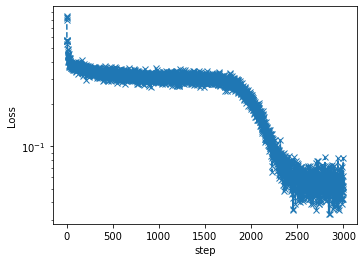

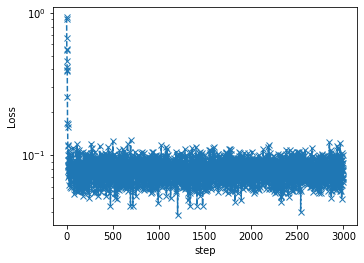

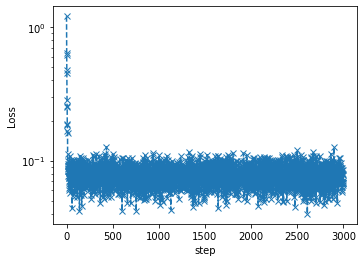

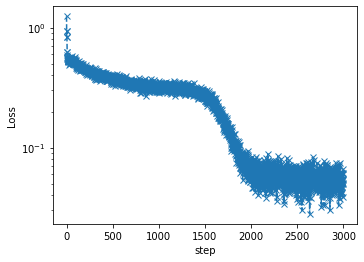

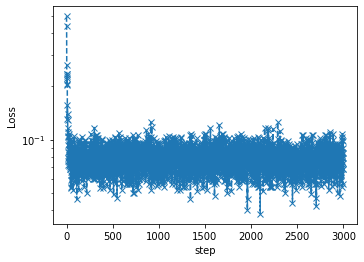

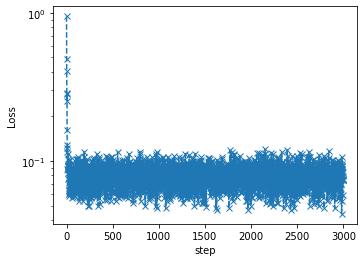

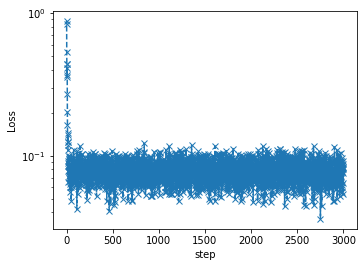

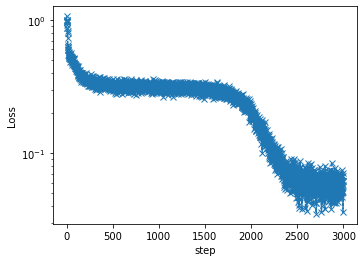

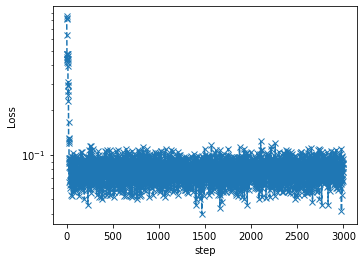

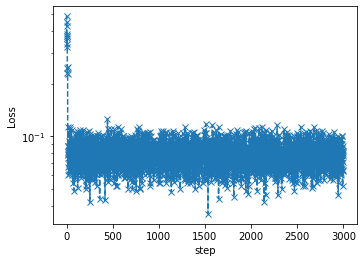

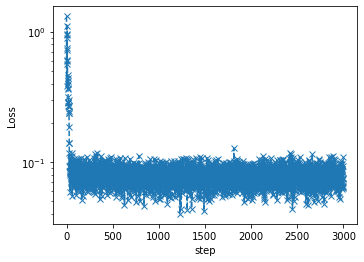

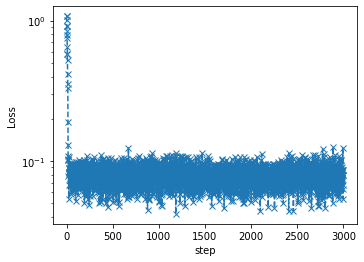

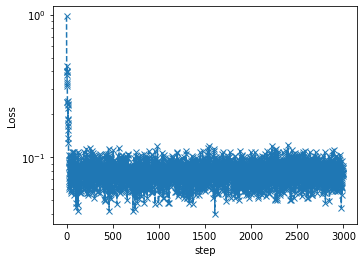

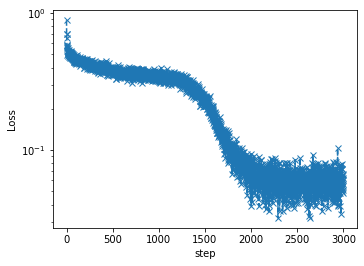

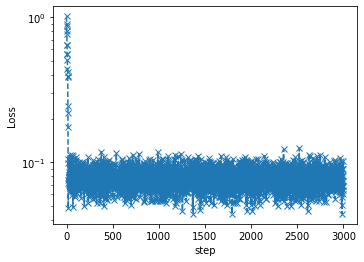

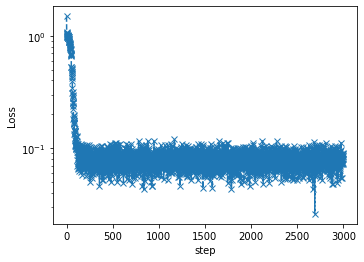

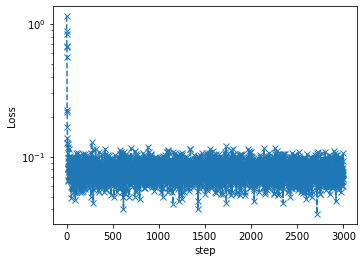

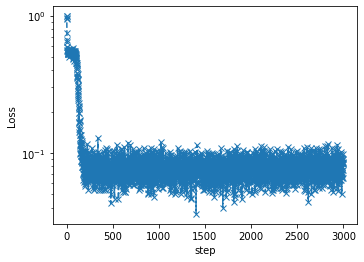

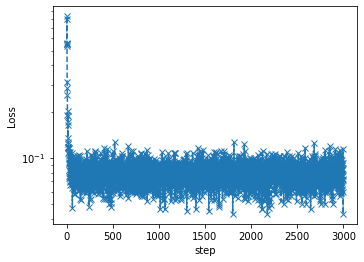

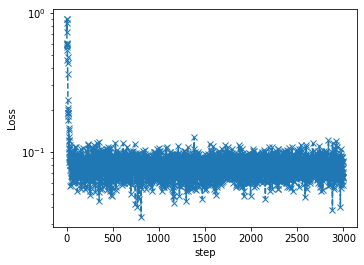

In [483]:
seeds = np.arange(20) + 10
for seed in seeds:
#     loss = np.load(f'data_rike/cost_bh_L12_trash2_d48_v5_seed{seed}.npy', allow_pickle=True)
#     params = [[48,5]]

#     loss = np.load(f'data_rike/cost_bh_L12_trash2_d2_v5_seed{seed}.npy', allow_pickle=True)
#     loss = np.load(f'data_rike/cost_bh_L12_trash4_d2_v5_seed{seed}.npy', allow_pickle=True)
#     params = [[2,5]]
    
#     loss = np.load(f'data_rike/loss_bh_L12_trash2_d10_v10_seed{seed}.npy', allow_pickle=True)
#     loss = np.load(f'data_rike/loss_bh_L12_trash4_d10_v10_seed{seed}.npy', allow_pickle=True)
    
    loss = np.load(f'data_rike/loss_bh_L12_trash2_d25_v47_seed{seed}.npy', allow_pickle=True)
#     loss = np.load(f'data_rike/loss_bh_L12_trash4_d25_v47_seed{seed}.npy', allow_pickle=True)
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(loss, "x--")
    plt.yscale("log")
    plt.xlabel("step")
    plt.ylabel("Loss")